In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from noise_scheduler import *

timesteps = 500
device = torch.device('cpu')


$\bar{\alpha}$ is how much noise you get at each time step.

In [2]:
def plot_noise_scheduling(noise):
    # plot beta, alpha, alphabar, and sigma as subplots
    fig, axs = plt.subplots(2, 3, figsize=(8, 4))
    axs[0, 0].plot(noise.b_t)
    axs[0, 0].set_title('β')
    axs[0, 1].plot(noise.a_t)
    axs[0, 1].set_title(r'$\alpha$')
    axs[0, 2].plot(noise.b_t.sqrt())
    axs[0, 2].set_title(r'$\sqrt{\beta}$')
    axs[1, 0].plot(noise.ab_t)
    axs[1, 0].set_title(r'$\bar{\alpha} = e^{\sum_{s=1}^{t} \log(a_{s})}$')
    axs[1, 1].plot(noise.ab_t)
    axs[1, 1].set_title(r'$\bar{\alpha}$ = $\prod_{s=1}^{t} \alpha_s$')
    axs[1, 2].axis('off')

    # Adjust the space between subplots
    plt.subplots_adjust(wspace=0.4, hspace=0.8)

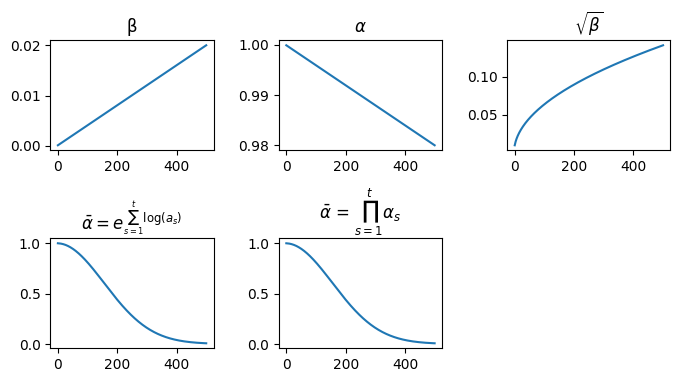

In [3]:
noise = NoiseScheduler(timesteps, device, NoiseScheduler.LINEAR)
plot_noise_scheduling(noise)

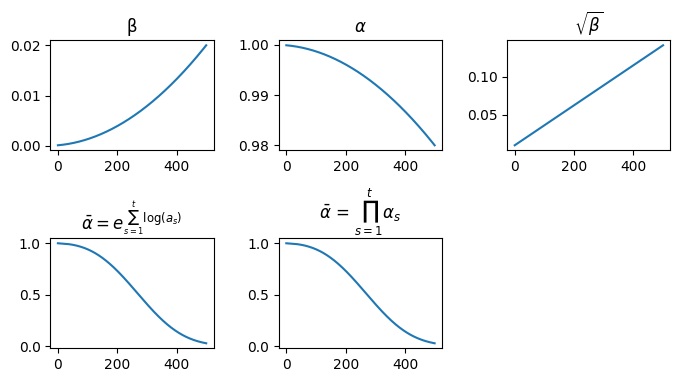

In [4]:
noise = NoiseScheduler(timesteps, device, NoiseScheduler.QUADRATIC)
plot_noise_scheduling(noise)

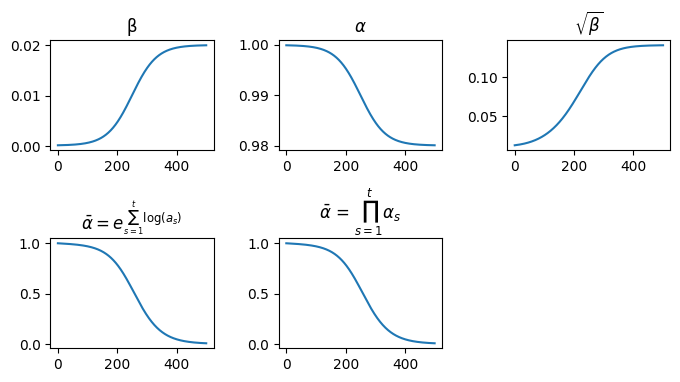

In [5]:
noise = NoiseScheduler(timesteps, device, NoiseScheduler.SIGMOID)
plot_noise_scheduling(noise)

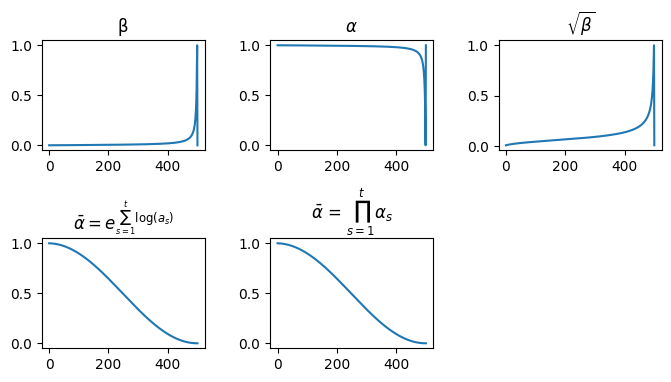

In [6]:
noise = NoiseScheduler(timesteps, device, NoiseScheduler.COSINE)
plot_noise_scheduling(noise)

In [7]:
def denoise_add_noise(self, x, t, pred_noise, z=None):
        if z is None:
            z = torch.randn_like(x)
        noise = self.b_t.sqrt()[t] * z
        mean = (x - pred_noise * ((1 - self.a_t[t]) / (1 - self.ab_t[t]).sqrt())) / self.a_t[t].sqrt()
        return mean + noise

# Sampling

1. $\mathbf{x}_T \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$

2. for $t=T, \ldots, 1$ do

3. $\mathbf{z} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ if $t>1$, else $\mathbf{z}=\mathbf{0}$

4. $\mathbf{x}_{t-1}=\frac{1}{\sqrt{\alpha_t}}\left(\mathbf{x}_t-\frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}} \mathbf{z}_\theta\left(\mathbf{x}_t, t\right)\right)+\sigma_t \mathbf{z}$, noise added back is $\sigma_t \times z = \sqrt{\beta_t} \times z$, predicted noise is $\mathbf{z}_\theta$

5. end for

6. return $x_0$

# Training

1. repeat

2. $\mathbf{x}_0 \sim q\left(\mathbf{x}_0\right)$

3. $t \sim \operatorname{Uniform}(\{1, \ldots, T\})$

4. $\boldsymbol{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$

5. Take gradient descent step on
$$
\nabla_\theta\left\|\boldsymbol{\epsilon}-\boldsymbol{\epsilon}_\theta\left(\sqrt{\bar{\alpha}_t} \mathbf{x}_0+\sqrt{1-\bar{\alpha}_t} \boldsymbol{\epsilon}, t\right)\right\|^2
$$

6. until converged

In [12]:
# read from numpy label file
labels = np.load('../sprite_labels_nc_1788_16x16.npy')
print(labels.shape)
labels

(89400, 5)


array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

max [255 255 255], min [0 0 0]


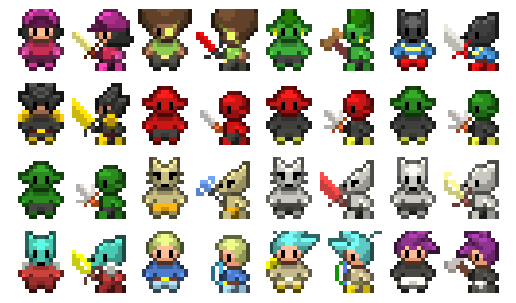

In [22]:
# read from numpy sprite file
sprites = np.load('../sprites_1788_16x16.npy')
sprites.shape

xmax = sprites[0].max((0,1))
xmin = sprites[0].min((0,1))
print(f"max {xmax}, min {xmin}")

# read first 10 image from sprites
for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.imshow(sprites[i])
    plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=-0.5)

In [ ]:
def plot_gpu_perf(df):
    # find the max of the all memory-related columns
    mem_columns = ['CurrentMem', 'PeakMem']

    # Find the maximum of the memory-related columns
    max_values = df[mem_columns].max()
    max_mem = max_values.max()
    i=0
    while max_mem > 1024:
        max_mem = max_mem / 1024
        i += 1

    #divide all memory-related columns by 1024^i
    df[mem_columns] = df[mem_columns] / 1024**i
    suffixes = ['B', 'KB', 'MB', 'GB', 'TB', 'PB']

    # Create a figure and an array of axes
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    axs[0,0].plot(df['CurrentMem'], label=f'Current ({suffixes[i]})')
    axs[0,0].plot(df['PeakMem'], label=f'Peak ({suffixes[i]})')
    axs[0,0].legend()

    axs[0,1].plot(df['Usage'], label='Usage')
    axs[0,1].legend()

    axs[1,0].plot(df['Temperature'], label='Temperature')
    axs[1,0].legend()

    axs[1,1].plot(df['Power'], label='power')
    axs[1,1].legend()

    # Show the plot
    plt.show()

In [ ]:
# Read the CSV file
df = pd.read_csv('../data/gpu_snapshots_sampling.csv')
plot_gpu_perf(df)


In [ ]:
# Read the CSV file
df = pd.read_csv('../data/gpu_snapshots_training.csv')
plot_gpu_perf(df)


In [ ]:
df = pd.read_csv('../data/gpu_snapshots_training_batch1000.csv')
plot_gpu_perf(df)


In [ ]:
df = pd.read_csv('../data/gpu_snapshots_training_batch7000.csv')
plot_gpu_perf(df)

In [16]:
import einops


(-0.5, 15.5, 79.5, -0.5)

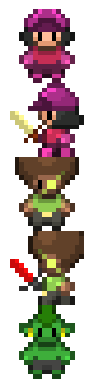

In [34]:
# https://github.com/arogozhnikov/einops/blob/master/docs/1-einops-basics.ipynb
a = einops.rearrange(sprites[:5], 'b h w c -> (b h) w c')

plt.imshow(a)
plt.axis('off')


(-0.5, 63.5, 63.5, -0.5)

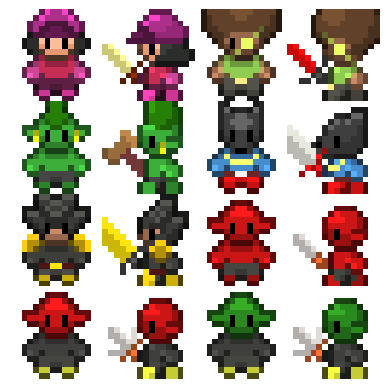

In [37]:
a = einops.rearrange(sprites[:16], '(b1 b2) h w c -> (b1 h) (b2 w) c ', b1=4)
plt.imshow(a)
plt.axis('off')